Logs   
- [2023/03/08]   
  Restart this notebook if you change the scratch library

In [1]:
import requests
import csv
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from typing import List, NamedTuple, Dict, Tuple
from collections import Counter, defaultdict

from scratch.linear_algebra import LinearAlgebra as la
from scratch.linear_algebra import Vector
from scratch.machine_learning import MachineLearning as ml

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

Predicting a vote for a person in specific area if we have the neighbourhood data 

## The Model

k-nearest neighbours will not help us to understand the driver of a phenomena
which influents the data. Another model will help, but not k-nearest neighbours

Let's say we've picked a number $k$ like 3 or 5. Then, when we want to classify some new
data point, we find the $k$ nearest labeled points and let them vote on the new output

In [3]:
def raw_majority_vote(labels: List[str]) -> str:
  votes = Counter(labels)
  winner, _ = votes.most_common(1)[0]
  return winner

In [4]:
raw_majority_vote(['a', 'b', 'c', 'b'])

'b'

If we have a tie, the above method would not resolve it.
Let's implement $k$-nearest neighbours

In [5]:
def majority_vote(labels: List[str]) -> str:
  """Assumes that labels are ordered from nearest to farthest.
     The first index position is the origin and the last index
     position is the farthest position"""
  vote_counts = Counter(labels)
  winner, winner_count = vote_counts.most_common(1)[0]
  num_winners = len([count for count in vote_counts.values()
                      if count == winner_count])
  
  if num_winners == 1:
    return winner                       # unique winner, so return it
  else:
    return majority_vote(labels[:-1])   # try again without the farthest


# Tie, so look at first 4, then 'b'
majority_vote(['a', 'b', 'c', 'b', 'a'])

'b'

Improve the above function using `LabeledPoint` class.

In [6]:
class LabeledPoint(NamedTuple):
  point: Vector
  label: str


def knn_classify(k: int, labeled_points: List[LabeledPoint], new_point: Vector) -> str:
  # Order the labeled points from nearest to farthest
  by_distance = sorted(labeled_points, 
                       key=lambda lp: la.distance(lp.point, new_point))
  
  # Find the labels for the k closest
  k_nearest_labels = [lp.label for lp in by_distance[:k]]

  # and let them vote.
  return majority_vote(k_nearest_labels)

In [7]:
# Tie, so look at first 4, then 'b'
majority_vote(['a', 'b', 'c', 'b', 'a'])

'b'

## Example: The Iris Dataset

In [8]:
data = requests.get(
  "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

with open('iris.data', 'w') as f:
  f.write(data.text)

Representing our data using `LabeledPoint`

In [9]:
def parse_iris_row(row: List[str]) -> LabeledPoint:
  """sepal_length, sepal_width, petal_length, petal_width, class"""
  measurements = [float(value) for value in row[:-1]]

  # class is e.g. "Iris-virginica"; we just want "virginica"
  if len(row) != 0:
    label = row[-1].split("-")[-1]
    return LabeledPoint(measurements, label)
  else:
    return None


with open("iris.data") as f:
  reader = csv.reader(f)
  iris_data = [parse_iris_row(row) for row in reader]

iris_data = [row for row in iris_data if row != None]

# We'll also group just the points by species/label so we can plot them
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
  points_by_species[iris.label].append(iris.point)

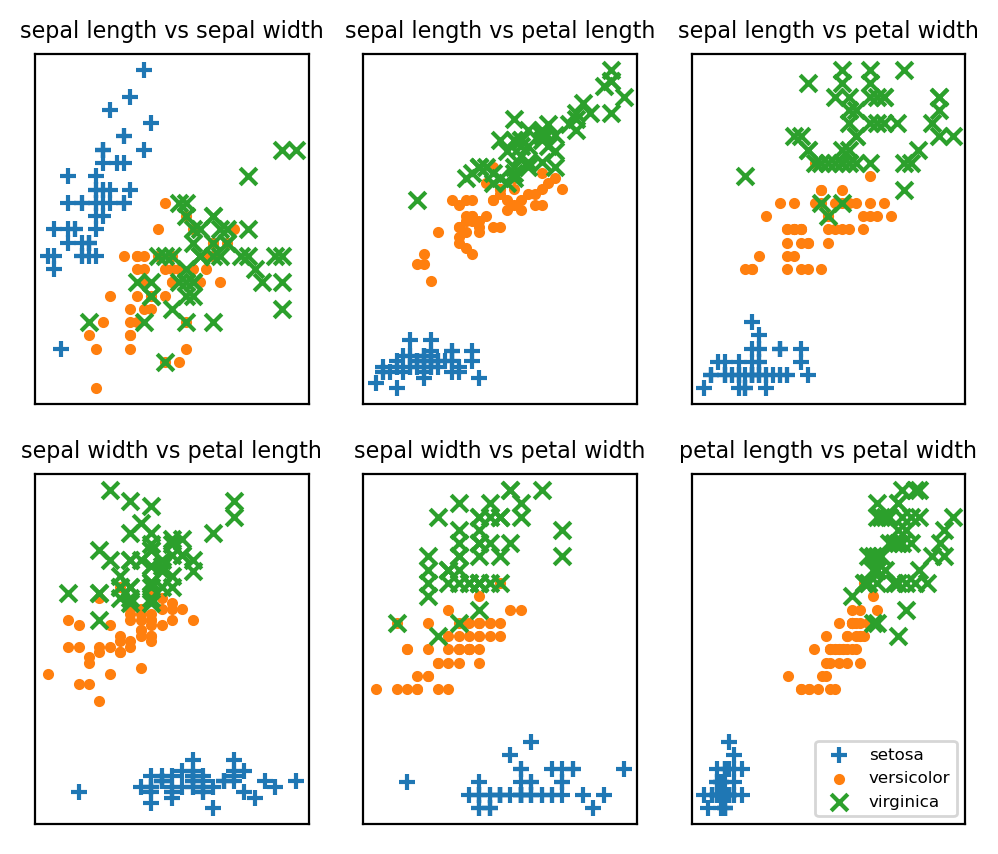

In [10]:
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']     # we have 3 classes, so 3 markers

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(6, 5), dpi=200)

for row in range(2):
  for col in range(3):
    i, j = pairs[3 * row + col]

    ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])

    for mark, (species, points) in zip(marks, points_by_species.items()):
      xs = [point[i] for point in points]
      ys = [point[j] for point in points]

      ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc="lower right", prop={'size': 6})
plt.show()

Split the data into a test and a training set

In [11]:
seed = 2023_04_19
rng = np.random.default_rng(seed)

iris_train, iris_test = ml.split_data(iris_data, 0.70, rng)

print(f"len(iris_train) = {len(iris_train)}")
print(f"len(iris_test) = {len(iris_test)}")

len(iris_train) = 105
len(iris_test) = 45


Predict with $k$-NN with $k=5$

In [12]:
# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
  predicted = knn_classify(5, iris_train, iris.point)
  actual = iris.label


  if predicted == actual:
    num_correct += 1
  
  confusion_matrix[(predicted, actual)] += 1


pct_correct = num_correct / len(iris_test)
print(pct_correct)
print(confusion_matrix)

0.9555555555555556
defaultdict(<class 'int'>, {('versicolor', 'versicolor'): 16, ('virginica', 'virginica'): 15, ('setosa', 'setosa'): 12, ('virginica', 'versicolor'): 2})


## The Curse of Dimensionality

Generating random points and random distances

In [13]:
def random_distances(dim: int, num_pairs: int, rng) \
    -> List[float]:

  return [la.distance(rng.random(dim), rng.random(dim)) for _ in range(num_pairs)]

For every dimension from 1 to 100, we'll compute 10_000 distance and uses 
those to compute the average distance between points and the minimum 
distance between points in each dimension

In [14]:
dimensions = range(1, 100)

avg_distances = []
min_distances = []

seed = 2023_03_19
rng = np.random.default_rng(seed)
for dim in tqdm.tqdm(dimensions, desc="Curse of dimensionality"):
  distances = random_distances(dim, 10_000, rng)    # 10,000 randomn pairs
  avg_distances.append(sum(distances) / 10_000)           # track the average
  min_distances.append(min(distances))                    # trach the minimum

Curse of dimensionality: 100%|██████████| 99/99 [00:16<00:00,  6.05it/s]


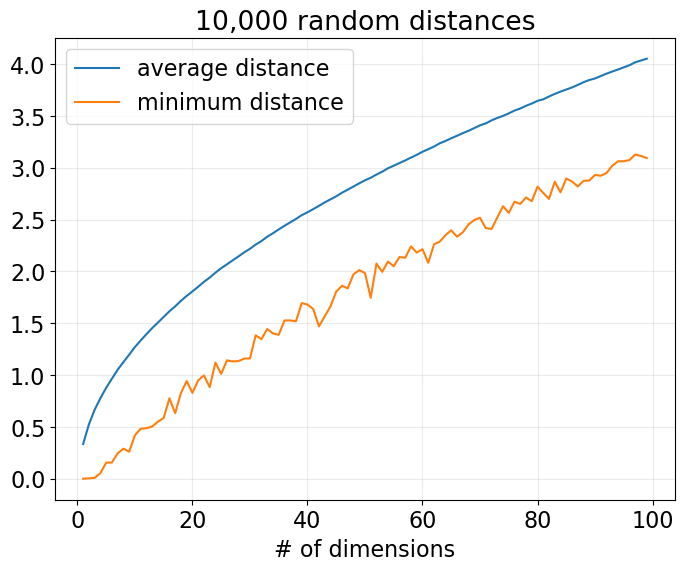

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

x_dims = list(dimensions)

ax.plot(x_dims, avg_distances, label="average distance")
ax.plot(x_dims, min_distances, label="minimum distance")

ax.set_xlabel("# of dimensions")
ax.set_title("10,000 random distances")

ax.grid('on')
ax.legend(loc="upper left")


plt.show(fig)

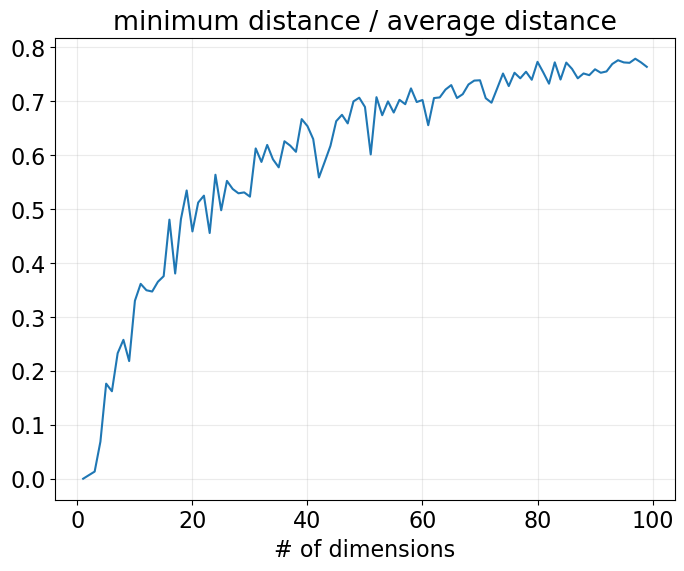

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

x_dims = list(dimensions)

y_ratio = [min_dist / avg_dist for min_dist, avg_dist 
            in zip(min_distances, avg_distances)]
ax.plot(x_dims, y_ratio)

ax.set_xlabel("# of dimensions")
ax.set_title("minimum distance / average distance")

ax.grid('on')


plt.show(fig)

In low-dimensional datasets, the closest points tend to be much closer
than the average. But two points are close only if they are close in
every dimension, and every extra dimension&mdash;even if just noise&mdash;
is another opportunity for each point to be farther away from every
other point. When you haev a lot of dimensions, it's likely that the
closest point aren't much closer than evarage, so two points
being close doesn't mean very much (unless there's a lot of structure
in your data that makes it behaves as if it were much lower-dimensional)

So if you're trying to use nearest neighbors in higher dimensions, it's probably a good idea to do some kind of dimensionality reduction first.